###  Annie's Magic Numbers - Optimized Databricks Notebook (PySpark)
###  Author: Alonso Castro
###  Purpose: Advanced sales and inventory analysis with strategic insights

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [0]:
# ================================================================
# 1. DATA INGESTION WITH VALIDATION
# ================================================================

def load_and_validate_tables():
    """Load tables with error handling and basic validation"""
    try:
        tables = {
            'purchases': spark.table("workspace.default.purchases_final_12312016"),
            'prices': spark.table("workspace.default.2017_purchase_prices_dec"),
            'begin_inv': spark.table("workspace.default.beg_inv_final_12312016"),
            'end_inv': spark.table("workspace.default.end_inv_final_12312016"),
            'invoices': spark.table("workspace.default.invoice_purchases_12312016"),
            'sales': spark.table("workspace.default.sales_final_12312016")
        }
        
        for name, df in tables.items():
            count = df.count()
            print(f"✅ {name}: {count:,} records loaded")
            if count == 0:
                print(f"⚠️ Warning: {name} table is empty")
        
        return tables
    except Exception as e:
        print(f"❌ Error loading tables: {str(e)}")
        raise

tables = load_and_validate_tables()

print("✅ Showing tables...\n")

# Display the first rows of each table
tables['purchases'].show()
tables['prices'].show()
tables['begin_inv'].show()
tables['end_inv'].show()
tables['invoices'].show()
tables['sales'].show()


✅ purchases: 2,372,474 records loaded
✅ prices: 12,261 records loaded
✅ begin_inv: 206,529 records loaded
✅ end_inv: 224,489 records loaded
✅ invoices: 5,543 records loaded
✅ sales: 12,825,363 records loaded
✅ Showing tables...

+--------------------+-----+-----+--------------------+-----+------------+--------------------+--------+----------+-------------+-----------+----------+-------------+--------+-------+--------------+
|         InventoryId|Store|Brand|         Description| Size|VendorNumber|          VendorName|PONumber|    PODate|ReceivingDate|InvoiceDate|   PayDate|PurchasePrice|Quantity|Dollars|Classification|
+--------------------+-----+-----+--------------------+-----+------------+--------------------+--------+----------+-------------+-----------+----------+-------------+--------+-------+--------------+
| 59_CLAETHORPES_4662|   59| 4662|Capt Morgan White...|1.75L|        3960|DIAGEO NORTH AMER...|   10260|2016-05-17|   2016-05-23| 2016-06-06|2016-07-14|        15.38|       6

In [0]:
# ================================================================
# 2. DATA PREPARATION AND CLEANING
# ================================================================

def prepare_sales_data(sales_df):
    """Clean and prepare sales data with proper data types"""
    return sales_df.select(
        F.col("InventoryId"),
        F.col("Store"), 
        F.col("Brand"),
        F.col("Description"),
        F.col("Size"),
        F.col("SalesQuantity").cast(IntegerType()).alias("SalesQuantity"),
        F.col("SalesDollars").cast(DoubleType()).alias("SalesDollars"),
        F.col("SalesPrice").cast(DoubleType()).alias("SalesPrice"),
        F.col("SalesDate"),
        F.col("Volume"),
        F.col("Classification"),
        F.col("VendorNo"),
        F.col("VendorName")
    ).filter(
        (F.col("SalesQuantity") > 0) & 
        (F.col("SalesDollars") > 0) &
        F.col("InventoryId").isNotNull()
    )

def prepare_purchases_data(purchases_df):
    """Clean and prepare purchases data"""
    return purchases_df.select(
        F.col("InventoryId"),
        F.col("Store"),
        F.col("Brand"),
        F.col("Description"), 
        F.col("Size"),
        F.col("PurchasePrice").cast(DoubleType()).alias("PurchasePrice"),
        F.col("Quantity").cast(IntegerType()).alias("PurchaseQuantity"),
        F.col("Dollars").cast(DoubleType()).alias("PurchaseDollars"),
        F.col("Classification"),
        F.col("VendorNumber"),
        F.col("VendorName")
    ).filter(
        (F.col("PurchasePrice") > 0) &
        (F.col("Quantity") > 0) &
        F.col("InventoryId").isNotNull()
    )

def prepare_inventory_data(begin_inv_df, end_inv_df):
    """Prepare inventory data with proper joins"""
    begin_clean = begin_inv_df.select(
        F.col("InventoryId"),
        F.col("onHand").cast(IntegerType()).alias("BeginInventory")
    ).filter(F.col("InventoryId").isNotNull())
    
    end_clean = end_inv_df.select(
        F.col("InventoryId"),
        F.col("onHand").cast(IntegerType()).alias("EndInventory")
    ).filter(F.col("InventoryId").isNotNull())
    
    return begin_clean, end_clean

# Prepare all datasets
sales_clean = prepare_sales_data(tables['sales'])
purchases_clean = prepare_purchases_data(tables['purchases'])
begin_inv_clean, end_inv_clean = prepare_inventory_data(tables['begin_inv'], tables['end_inv'])

print("✅ Data preparation completed")



✅ Data preparation completed


In [0]:
# ================================================================
# 3. COST CALCULATION WITH WEIGHTED AVERAGE
# ================================================================

def calculate_weighted_avg_cost(purchases_df):
    """Calculate weighted average cost per product"""
    return purchases_df.groupBy("InventoryId", "Brand", "Description").agg(
        F.sum(F.col("PurchaseDollars")).alias("TotalPurchaseDollars"),
        F.sum(F.col("PurchaseQuantity")).alias("TotalPurchaseQuantity")
    ).withColumn(
        "WeightedAvgCost",
        F.when(F.col("TotalPurchaseQuantity") > 0,
               F.col("TotalPurchaseDollars") / F.col("TotalPurchaseQuantity"))
        .otherwise(0)
    )

weighted_costs = calculate_weighted_avg_cost(purchases_clean)

In [0]:
# ================================================================
# 4. COMPREHENSIVE PROFIT AND MARGIN ANALYSIS
# ================================================================

# Join sales with costs
sales_with_cost = sales_clean.alias("s").join(
    weighted_costs.alias("c"),
    ["InventoryId", "Brand", "Description"],
    "left"
).select(
    F.col("s.*"),
    F.coalesce(F.col("c.WeightedAvgCost"), F.lit(0)).alias("UnitCost"),
    F.coalesce(F.col("c.TotalPurchaseQuantity"), F.lit(0)).alias("TotalPurchased")
)

# Calculate comprehensive metrics
sales_analysis = sales_with_cost.withColumn(
    "TotalCost", F.col("UnitCost") * F.col("SalesQuantity")
).withColumn(
    "Profit", F.col("SalesDollars") - F.col("TotalCost")
).withColumn(
    "MarginPercent", 
    F.when(F.col("SalesDollars") > 0,
           (F.col("Profit") / F.col("SalesDollars")) * 100)
    .otherwise(0)
).withColumn(
    "ROI_Percent",
    F.when(F.col("TotalCost") > 0,
           (F.col("Profit") / F.col("TotalCost")) * 100)
    .otherwise(0)
)

# Add inventory information
sales_final = sales_analysis.alias("sf").join(
    begin_inv_clean.alias("bi"), ["InventoryId"], "left"
).join(
    end_inv_clean.alias("ei"), ["InventoryId"], "left"
).select(
    F.col("sf.*"),
    F.coalesce(F.col("bi.BeginInventory"), F.lit(0)).alias("BeginInventory"),
    F.coalesce(F.col("ei.EndInventory"), F.lit(0)).alias("EndInventory")
).withColumn(
    "InventoryTurnover",
    F.when(F.col("BeginInventory") > 0,
           F.col("SalesQuantity") / F.col("BeginInventory"))
    .otherwise(0)
)

print(f"✅ Analysis dataset created: {sales_final.count():,} records")

✅ Analysis dataset created: 12,825,308 records


In [0]:
# ================================================================
# 5. STRATEGIC ANALYSIS AND REPORTING
# ================================================================

def create_product_summary():
    """Create comprehensive product-level analysis"""
    return sales_final.groupBy("InventoryId", "Brand", "Description", "Classification").agg(
        F.sum("SalesQuantity").alias("TotalUnitsSold"),
        F.sum("SalesDollars").alias("TotalRevenue"),
        F.sum("Profit").alias("TotalProfit"),
        F.avg("MarginPercent").alias("AvgMarginPercent"),
        F.avg("ROI_Percent").alias("AvgROI"),
        F.sum("EndInventory").alias("CurrentInventory"),
        F.avg("InventoryTurnover").alias("AvgTurnover"),
        F.count("*").alias("TransactionCount")
    ).withColumn(
        "ProfitPerUnit", F.col("TotalProfit") / F.col("TotalUnitsSold")
    ).withColumn(
        "RevenuePerUnit", F.col("TotalRevenue") / F.col("TotalUnitsSold")
    )

def create_brand_summary():
    """Create comprehensive brand-level analysis"""
    return sales_final.groupBy("Brand", "Description").agg(
        F.sum("SalesQuantity").alias("TotalUnitsSold"),
        F.sum("SalesDollars").alias("TotalRevenue"),
        F.sum("Profit").alias("TotalProfit"),
        F.avg("MarginPercent").alias("AvgMarginPercent"),
        F.avg("ROI_Percent").alias("AvgROI"),
        F.sum("EndInventory").alias("CurrentInventory"),
        F.avg("InventoryTurnover").alias("AvgTurnover"),
        F.countDistinct("InventoryId").alias("UniqueProducts"),
        F.count("*").alias("TransactionCount")
    ).withColumn(
        "ProfitPerUnit", F.col("TotalProfit") / F.col("TotalUnitsSold")
    ).withColumn(
        "RevenuePerTransaction", F.col("TotalRevenue") / F.col("TransactionCount")
    )

product_summary = create_product_summary()
brand_summary = create_brand_summary()

In [0]:
# ================================================================
# 6. TOP PERFORMERS ANALYSIS
# ================================================================

# Top 10 Products by Profit
top_products_profit = product_summary.orderBy(F.col("TotalProfit").desc()).limit(10)

# Top 10 Products by Margin
top_products_margin = product_summary.filter(F.col("TotalRevenue") > 1000).orderBy(F.col("AvgMarginPercent").desc()).limit(10)

# Top 10 Brands by Profit  
top_brands_profit = brand_summary.orderBy(F.col("TotalProfit").desc()).limit(10)

# Top 10 Brands by Margin
top_brands_margin = brand_summary.filter(F.col("TotalRevenue") > 5000).orderBy(F.col("AvgMarginPercent").desc()).limit(10)

In [0]:
# ================================================================
# 7. STRATEGIC OPPORTUNITIES ANALYSIS
# ================================================================

def identify_strategic_opportunities():
    """Identify products with strategic potential instead of just dropping them"""
    
    # Products losing money but with high volume (price adjustment opportunity)
    high_volume_losers = product_summary.filter(
        (F.col("TotalProfit") < 0) & 
        (F.col("TotalUnitsSold") > 50)
    ).withColumn(
        "PriceAdjustmentNeeded", F.abs(F.col("ProfitPerUnit"))
    ).select(
        "Brand", "Description", "TotalUnitsSold", "TotalRevenue", 
        "TotalProfit", "AvgMarginPercent", "PriceAdjustmentNeeded",
        F.lit("Price Adjustment").alias("Strategy")
    )
    
    # Low margin but high turnover (volume discount opportunity)
    high_turnover_low_margin = product_summary.filter(
        (F.col("AvgMarginPercent").between(0, 15)) & 
        (F.col("AvgTurnover") > 2) &
        (F.col("TotalProfit") > 0)
    ).select(
        "Brand", "Description", "TotalUnitsSold", "TotalRevenue",
        "TotalProfit", "AvgMarginPercent", "AvgTurnover",
        F.lit("Volume Strategy").alias("Strategy")
    )
    
    # High inventory, low sales (promotion opportunity)
    overstocked_products = product_summary.filter(
        (F.col("CurrentInventory") > 100) & 
        (F.col("AvgTurnover") < 0.5) &
        (F.col("TotalProfit") > 0)
    ).select(
        "Brand", "Description", "CurrentInventory", "TotalUnitsSold",
        "TotalProfit", "AvgMarginPercent", "AvgTurnover",
        F.lit("Liquidation/Promotion").alias("Strategy")
    )
    
    # Products to genuinely consider dropping (consistent losers with low volume)
    products_to_drop = product_summary.filter(
        (F.col("TotalProfit") < 0) & 
        (F.col("TotalUnitsSold") < 50) &
        (F.col("AvgMarginPercent") < 5)
    ).select(
        "Brand", "Description", "TotalUnitsSold", "TotalRevenue",
        "TotalProfit", "AvgMarginPercent", 
        F.lit("Consider Discontinuing").alias("Strategy")
    )
    
    return high_volume_losers, high_turnover_low_margin, overstocked_products, products_to_drop

strategic_opportunities = identify_strategic_opportunities()

In [0]:
# ================================================================
# 8. PERFORMANCE CATEGORIZATION
# ================================================================

def categorize_products():
    """Categorize products into performance tiers"""
    return product_summary.withColumn(
        "PerformanceCategory",
        F.when((F.col("TotalProfit") > 1000) & (F.col("AvgMarginPercent") > 20), "Star Products")
        .when((F.col("TotalProfit") > 500) & (F.col("AvgMarginPercent") > 10), "Strong Performers") 
        .when((F.col("TotalProfit") > 0) & (F.col("AvgMarginPercent") > 5), "Solid Contributors")
        .when((F.col("TotalProfit") > 0) & (F.col("TotalUnitsSold") > 100), "Volume Players")
        .when((F.col("TotalProfit") < 0) & (F.col("TotalUnitsSold") > 50), "Strategic Opportunities")
        .otherwise("Needs Review")
    )

product_categories = categorize_products()

In [0]:
# ================================================================
# 9. DISPLAY RESULTS
# ================================================================

print("=" * 60)
print("📊 ANNIE'S MAGIC NUMBERS - STRATEGIC ANALYSIS REPORT")
print("=" * 60)

print("\n🏆 TOP 10 PRODUCTS BY PROFIT")
display(top_products_profit.select("Brand", "Description", "TotalUnitsSold", "TotalRevenue", "TotalProfit", "AvgMarginPercent"))

print("\n💎 TOP 10 PRODUCTS BY MARGIN")  
display(top_products_margin.select("Brand", "Description", "TotalUnitsSold", "TotalRevenue", "TotalProfit", "AvgMarginPercent"))

print("\n🏅 TOP 10 BRANDS BY PROFIT")
display(top_brands_profit.select("Brand", "Description" , "TotalUnitsSold", "TotalRevenue", "TotalProfit", "AvgMarginPercent", "UniqueProducts"))

print("\n⭐ TOP 10 BRANDS BY MARGIN")
display(top_brands_margin.select("Brand", "Description" , "TotalUnitsSold", "TotalRevenue", "TotalProfit", "AvgMarginPercent", "UniqueProducts"))

print("\n🎯 STRATEGIC OPPORTUNITIES")
print("\n📈 High Volume Losers (Price Adjustment Needed):")
display(strategic_opportunities[0])

print("\n🔄 High Turnover, Low Margin (Volume Strategy):")
display(strategic_opportunities[1])

print("\n📦 Overstocked Products (Promotion Opportunity):")
display(strategic_opportunities[2])

print("\n⚠️ Products to Consider Discontinuing:")
display(strategic_opportunities[3])

print("\n📊 PRODUCT PERFORMANCE CATEGORIES")
performance_summary = product_categories.groupBy("PerformanceCategory").agg(
    F.count("*").alias("ProductCount"),
    F.sum("TotalProfit").alias("CategoryProfit"),
    F.avg("AvgMarginPercent").alias("AvgMargin")
).orderBy(F.col("CategoryProfit").desc())

display(performance_summary)

📊 ANNIE'S MAGIC NUMBERS - STRATEGIC ANALYSIS REPORT

🏆 TOP 10 PRODUCTS BY PROFIT


Brand Description TotalUnitsSold TotalRevenue TotalProfit AvgMarginPercent 1233 Jack Daniels No 7 Black 8754 312513.45999999973 82545.88000000002 27.69724674348653 3545 Ketel One Vodka 7962 247785.37999999998 73497.20000000003 30.06764116614111 3545 Ketel One Vodka 7621 238119.78999999995 71296.1 30.124033636378762 3405 Tito's Handmade Vodka 10008 301623.4 69537.87999999996 23.478884801138356 3545 Ketel One Vodka 7118 222438.82000000007 66625.79999999999 30.491341550207174 4261 Capt Morgan Spiced Rum 9924 221177.76000000007 60706.68000000002 29.45371049102818 8068 Absolut 80 Proof 9630 231762.19999999984 56111.0 25.22126235882716 3545 Ketel One Vodka 5999 186007.00999999998 54688.90000000004 30.412084378644394 1233 Jack Daniels No 7 Black 5514 198750.8599999999 53898.079999999965 27.4523511519899 1233 Jack Daniels No 7 Black 5482 197833.18000000005 53821.03999999998 27.51327949557242


💎 TOP 10 PRODUCTS BY MARGIN


Brand Description TotalUnitsSold TotalRevenue TotalProfit AvgMarginPercent 23383 Vivanco Rioja Rsva 08 69 1172.3100000000002 1172.3100000000002 100.0 22935 Adelsheim Bryan Creek Pnt Nr 15 1049.85 1049.85 100.0 19970 Ch Ducru Beaucallou 10 12 4799.88 4799.88 100.0 2166 The Macallan Double Cask 12 24 1324.76 1324.76 100.0 2368 Balvenie 17 Yr Doublewood 7 1019.9300000000001 1019.9300000000001 100.0 2405 Old Tahoe Honey Rye 53 1430.47 1430.47 100.0 10264 Fort Ross Pnt Nr Sonoma Cst 39 1169.6100000000001 1169.6100000000001 100.0 90089 Ch Lynch Bages 12 Pauillac 39 4679.61 4679.61 100.0 17394 Ch La Mission 09 Blanc Pessc 12 9599.88 9599.88 100.0 7872 Piper Heidsieck Brut 37 1674.63 1674.63 100.0


🏅 TOP 10 BRANDS BY PROFIT


Brand Description TotalUnitsSold TotalRevenue TotalProfit AvgMarginPercent UniqueProducts 1233 Jack Daniels No 7 Black 142049 5101919.510000001 1370292.2799999993 27.362629967357638 80 3545 Ketel One Vodka 135838 4223107.619999999 1249613.8000000003 30.139573961524015 80 4261 Capt Morgan Spiced Rum 200412 4475972.880000003 1235310.8399999994 28.833850040467368 80 8068 Absolut 80 Proof 187140 4538120.600000001 1124687.0 25.390229860205253 81 3405 Tito's Handmade Vodka 160247 4819073.490000002 1102945.5599999998 23.28684741281877 80 6570 Kendall Jackson Chard Vt RSV 214238 2326007.779999999 875616.5199999997 38.66953818060157 81 3858 Grey Goose Vodka 141860 3383912.4 863060.2 27.308316295111414 81 3489 Tanqueray 90481 2640491.189999999 764820.0600000011 29.42680756888015 80 1376 Jim Beam 107061 2435393.3899999997 691369.7000000001 29.06122456186355 81 2663 Dewars White Label 70122 2189368.78 687355.5399999996 33.224102405713936 80


⭐ TOP 10 BRANDS BY MARGIN


Brand Description TotalUnitsSold TotalRevenue TotalProfit AvgMarginPercent UniqueProducts 19967 Ch Branaire Ducru 10 Brdx 43 5417.570000000001 5417.570000000001 100.0 5 1991 The Macallan M Decanter 2 9999.98 9999.98 100.0 2 17601 Ch Palmer Margaux 09 Medoc 23 7819.7699999999995 7819.7699999999995 100.0 3 25421 Pol Roger 06 Brut Vintage Ro 69 6071.3099999999995 6071.3099999999995 100.0 7 17407 Ch La Mission 09 HB Pessac 13 10399.869999999999 10399.869999999999 100.0 2 22942 Clos de Marquis 09 St Julien 24 5615.76 5615.76 100.0 6 2367 Glenmorangie Pride 1 5799.99 5799.99 100.0 1 1676 Wild Turkey Master Keepers 37 5549.63 5549.63 100.0 7 35989 Ch Haut Brion 10 23 29899.77 29899.77 100.0 4 36070 Ch Cos D'Estournel 10 21 7517.79 7517.79 100.0 3


🎯 STRATEGIC OPPORTUNITIES

📈 High Volume Losers (Price Adjustment Needed):


Brand Description TotalUnitsSold TotalRevenue TotalProfit AvgMarginPercent PriceAdjustmentNeeded Strategy 45246 Shoofly Shiraz 59 412.4100000000002 -14.160000000000025 -3.433476394849791 0.24000000000000044 Price Adjustment 23519 Slow Press Chard 90 716.1000000000001 -171.30000000000007 -9.282582013101683 1.903333333333334 Price Adjustment 5270 Southern Comfort 452 594.4800000000012 -106.12000000000046 -21.28056874516433 0.23477876106194792 Price Adjustment 46156 Brookdale Cab Svgn Napa 72 1367.2800000000002 -655.9200000000001 -47.972617166929936 9.110000000000001 Price Adjustment 44714 Buehler Znfdl Napa 59 707.4100000000002 -89.67999999999991 -12.677231025854882 1.5199999999999985 Price Adjustment 24515 Cartlidge & Browne Chard 59 551.8100000000002 -2.200000000000008 10.154498466272049 0.03728813559322048 Price Adjustment 2729 Hell-Cat Maggie Irish Whisky 67 1251.3300000000004 -88.00000000000011 -7.289645608775511 1.3134328358208973 Price Adjustment 16189 Frescobaldi Tenuta Castglni 148 2551.519999999998 -93.2399999999999 -5.780936052881091 0.6299999999999993 Price Adjustment 25554 Brotte Espirit CdR 121 966.7900000000002 -139.1500000000001 -14.39299123904881 1.1500000000000008 Price Adjustment 25857 Cline Merlot Sonoma Coast 82 802.6800000000003 -214.93999999999988 -6.6514497072836045 2.6212195121951205 Price Adjustment 26710 Feudi Di San Gregorio Fiano 60 299.40000000000003 -256.19999999999993 -85.57114228456909 4.269999999999999 Price Adjustment 4277 Bacardi Limon Rum 95 386.5500000000003 -58.04999999999991 -14.390653694369547 0.6110526315789464 Price Adjustment 20429 Carpineto Montepulciano 11 64 319.35999999999996 -162.55999999999997 -50.901803607214426 2.5399999999999996 Price Adjustment 5270 Southern Comfort 390 551.1000000000006 -53.40000000000015 -20.581963926593954 0.1369230769230773 Price Adjustment 25554 Brotte Espirit CdR 87 695.1300000000002 -100.05000000000007 -14.392991239048808 1.1500000000000008 Price Adjustment 5270 Southern Comfort 71 70.28999999999998 -39.76 -56.565656565656575 0.5599999999999999 Price Adjustment 33331 Moletto Prosecco Della Marc 120 1078.8000000000004 -208.79999999999984 -19.354838709677416 1.7399999999999987 Price Adjustment 13338 C'est La Vie Pnt Nr/Syrh VDP 70 559.3000000000003 -93.80000000000007 -16.770963704630784 1.340000000000001 Price Adjustment 4102 Bacardi Raspberry Rum 94 1025.0600000000006 -2.3599999999999213 -1.0352388959134302 0.02510638297872257 Price Adjustment 4876 Skyy Infusion Tropical Mango 100 1101.0000000000005 -91.99999999999977 -10.325860590701662 0.9199999999999977 Price Adjustment 13339 C'Est La Vie Chard/Svgn Bl 182 1454.1800000000007 -189.2799999999998 -13.016270337922384 1.039999999999999 Price Adjustment 3283 New Amsterdam Apple Vodka 92 827.0800000000005 -128.80000000000007 -15.572858731924375 1.4000000000000008 Price Adjustment 1297 Jim Beam Black 213 210.86999999999998 -127.79999999999997 -60.606060606060545 0.5999999999999999 Price Adjustment 10666 Clayhouse Adobe Cntrl Cst Wh 161 971.3900000000004 -274.74999999999994 -25.978329895750427 1.7065217391304344 Price Adjustment 25904 Casal Garcia Sangria 732 3329.279999999993 -491.7600000000006 -8.361595486059011 0.6718032786885254 Price Adjustment 44714 Buehler Znfdl Napa 155 1858.450000000001 -235.60000000000002 -12.677231025854887 1.5200000000000002 Price Adjustment 4277 Bacardi Limon Rum 193 836.5700000000005 -66.67000000000009 -8.860337446380036 0.34544041450777246 Price Adjustment 25352 Cecchi Chianti DOCG 141 1221.9900000000005 -102.00000000000043 -3.0580752886879647 0.723404255319152 Price Adjustment 20706 A Proper Claret 251 2537.489999999998 -138.1700000000001 -4.50670450670451 0.5504780876494028 Price Adjustment 13339 C'Est La Vie Chard/Svgn Bl 96 767.0400000000004 -99.8399999999999 -13.016270337922384 1.039999999999999 Price Adjustment 25936 Roscato Rose Dolce 72 478.68000000000006 -153.47999999999996 8.161617716596243 2.131666666666666 Price Adjustment 5270 Southern Comfort 928 1178.720000000002


🔄 High Turnover, Low Margin (Volume Strategy):


Brand Description TotalUnitsSold TotalRevenue TotalProfit AvgMarginPercent AvgTurnover Strategy 5401 Jagermeister Liqueur 214 1098.860000000001 105.9 9.734647513018233 2.2061855670103094 Volume Strategy 5698 P & J Cold Soaked Pineapples 14 216.86 12.320000000000022 5.681084570690778 7.0 Volume Strategy 4060 Sauza Cucumber Chili Tequila 15 157.35 17.10000000000001 10.867492850333656 2.5 Volume Strategy 3518 Cabot Trail Maple Whisky 13 233.87 29.25 12.506948304613674 13.0 Volume Strategy 4326 Rumson's Coffee Rum 22 527.78 35.420000000000016 6.711129637348896 2.75 Volume Strategy 7849 Tooters Apple-tini 15 Pk 220 1989.800000000001 273.7999999999999 13.960679255451224 2.2916666666666665 Volume Strategy 2277 Kilbeggan Irish Whiskey 10 175.9 5.599999999999984 8.892069736911328 3.3333333333333335 Volume Strategy


📦 Overstocked Products (Promotion Opportunity):


Brand Description CurrentInventory TotalUnitsSold TotalProfit AvgMarginPercent AvgTurnover Strategy 2110 Barr an Uisce Irish Whiskey 135 14 139.9200000000001 22.391007553712484 0.0 Liquidation/Promotion 27083 Santa Margherita Rose Brut 270 27 170.09999999999994 31.515757878939453 0.0 Liquidation/Promotion 8016 La Vieille Ferme Wh Rhone 6191 606 1480.2000000000012 34.229898082293786 0.1254139072847682 Liquidation/Promotion 1468 Knob Creek Single Barrel Rsv 13338 205 2212.4999999999995 25.705935188754662 0.06422305764411021 Liquidation/Promotion 22902 Hermann J Wiemer Semi Dry Rs 396 42 244.37999999999985 34.41982490059548 0.06698564593301433 Liquidation/Promotion 46023 Spellbound Petite Sirah Cal 2254 347 1830.1400000000017 44.92548583267381 0.016838121118012424 Liquidation/Promotion 7279 Yago Sant'Gria Red 2288 163 599.6800000000007 44.246567986058835 0.05597527472527467 Liquidation/Promotion 24289 Thierry Delaunay Tour Svgn B 252 36 194.7599999999999 36.09072715143429 0.0 Liquidation/Promotion 36378 MezzaCorona Pnt Grigio 8362 1496 5225.139999999999 34.928829117582076 0.24516551950180276 Liquidation/Promotion 680 Midnight Moon Strawberry 105 7 139.92999999999998 100.0 0.04545454545454546 Liquidation/Promotion 18881 Middle Sister Pnt Nr Goodie 650 83 287.18 34.556875173213086 0.11608391608391601 Liquidation/Promotion 38888 Justin Cab Svgn Paso Robles 14454 278 3116.5799999999995 40.15443770459576 0.06347031963470312 Liquidation/Promotion 2713 Inver House Green Plaid 3-Y 343 69 294.1400000000001 27.660066193208692 0.1760204081632653 Liquidation/Promotion 8496 Jadot Chardonnay 232 89 341.9300000000002 24.684282428196713 0.1394984326018808 Liquidation/Promotion 8171 Leroux Blackberry Brandy 6525 248 69.44000000000004 28.282828282828223 0.03353617308992559 Liquidation/Promotion 1384 Bulleit 95 Rye 5504 194 1503.639999999996 29.33055244742372 0.03157552083333334 Liquidation/Promotion 2722 J & B Rare 260 20 88.0 20.00909504320145 0.11111111111111113 Liquidation/Promotion 13709 Jam Jar Sweet Shiraz 972 138 491.12000000000046 34.51959048289329 0.0774410774410775 Liquidation/Promotion 26399 Trapiche Malbec Mendoza Oak 6912 893 3172.1500000000046 49.65033968041766 0.14094065656565685 Liquidation/Promotion 36154 Frogs Leap Znfdl Napa 832 76 879.0 36.121702219908066 0.04175824175824172 Liquidation/Promotion 4330 Capt Morgan Spiced Rum 100 11172 600 3948.9999999999977 24.216963718933236 0.04311583788444965 Liquidation/Promotion 6552 Harveys Bristol Cream Sherry 5476 321 2889.0 39.14745541539807 0.13555743243243243 Liquidation/Promotion 16692 Chartron Trebuchet Chard Bou 720 94 623.34 37.941962626151266 0.1305555555555555 Liquidation/Promotion 26774 El Coto Blanco Rioja 594 89 242.96999999999986 22.768974145120932 0.0 Liquidation/Promotion 3837 Skyy Vodka 44551 2550 688.4999999999998 27.2727272727272 0.041400136376919874 Liquidation/Promotion 44269 Codorniu Original Spklg Cava 836 96 423.84000000000003 40.53727593787935 0.22966507177033488 Liquidation/Promotion 8102 Absolut Mandrin 12780 551 3543.3400000000006 25.737059819011115 0.08746031746031732 Liquidation/Promotion 3758 Margaritaville Gold Tequila 210 54 330.59999999999985 28.918330413575635 0.225 Liquidation/Promotion 3768 Jenkins Vodka 900 105 173.85000000000008 30.84599917698505 0.0 Liquidation/Promotion 4363 Capt Morgan Black Spiced Rum 225 25 231.49999999999994 28.06911185207639 0.25 Liquidation/Promotion 903 Bombay Sapphire Gin 236 64 509.79999999999956 29.690208670462308 0.13559322033898305 Liquidation/Promotion 1734 Duggans Dew O Kirkintilloch 310 31 149.23999999999978 21.259401315448983 0.043478260869565195 Liquidation/Promotion 24648 Mumm Napa Bl de Blanc 216 40 306.7999999999999 44.319297791138055 0.0 Liquidation/Promotion 31866 F Coppola Diamond Merlot 875 54 295.8400000000001 37.89384665588659 0.08120300751879699 Liquidation/Promotion 5128 Carolans Irish Cream 400 53 197.52999999999997 28.62114398230395 0.04732142857142861 Liquidation/Promotion 5890 Godiva Wh Chocolate Liq


⚠️ Products to Consider Discontinuing:


Brand Description TotalUnitsSold TotalRevenue TotalProfit AvgMarginPercent Strategy 4276 Goslings Gold Seal Rum 12 279.88 -6.200000000000017 4.935346980797344 Consider Discontinuing 25827 Angeline Cab Svgn California 24 201.36 -7.92000000000003 -14.974674731778475 Consider Discontinuing 45246 Shoofly Shiraz 48 335.5200000000001 -11.520000000000016 -3.433476394849791 Consider Discontinuing 25588 High Valley Znfdl 48 671.5200000000001 -300.96000000000004 -44.817726947819885 Consider Discontinuing 2729 Hell-Cat Maggie Irish Whisky 31 567.69 -52.0 -9.794147205674498 Consider Discontinuing 18947 Austin Hope 10 Grenache 6 119.94 -33.06 -27.563781890945478 Consider Discontinuing 4053 Bird Dog Strawberry Whiskey 44 613.5600000000003 -19.60000000000001 -4.948723360230086 Consider Discontinuing 25216 Castello D'Alba Vinho Tinta 28 209.71999999999997 -61.03999999999999 -29.105473965287043 Consider Discontinuing 4092 Bacardi Grapefruit Rum 30 315.7000000000001 -19.99999999999998 -6.780425129048976 Consider Discontinuing 16189 Frescobaldi Tenuta Castglni 12 191.88000000000002 -22.560000000000016 -11.757348342714199 Consider Discontinuing 24952 Jackhammer Chard Monterey 12 105.47999999999999 -4.920000000000018 -4.664391353811167 Consider Discontinuing 45246 Shoofly Shiraz 48 335.52 -11.520000000000014 -3.4334763948497904 Consider Discontinuing 13504 New Age Valentin Bianchi Whi 48 335.52 -13.920000000000002 -13.435324486570469 Consider Discontinuing 3283 New Amsterdam Apple Vodka 37 340.6300000000001 -43.79999999999999 -12.607170799362796 Consider Discontinuing 45602 Luigi Bosca RSV Pnt Nr 3 34.47 -4.74 -13.751087902523935 Consider Discontinuing 8535 Arrow Peppermint Schnapps 48 175.02000000000007 -2.5799999999999836 4.142202801796345 Consider Discontinuing 3387 Kinahan's Irish Whiskey 3 82.47 -9.81000000000001 -11.895234630774839 Consider Discontinuing 1297 Jim Beam Black 10 9.899999999999999 -6.000000000000002 -60.606060606060616 Consider Discontinuing 2230 Egan's Single Malt Irish Wh 5 172.45 -15.5 -8.988112496375763 Consider Discontinuing 4092 Bacardi Grapefruit Rum 9 99.91 -0.7999999999999936 -1.0021339444059412 Consider Discontinuing 24558 Dom La Fage Cve Nicholas VdP 12 81.48 -7.679999999999993 -9.425625920471271 Consider Discontinuing 21505 Margaride's Chard Arinto 48 335.52 -112.32000000000002 -33.476394849785386 Consider Discontinuing 2844 Diplome Dry Gin 10 259.9 -0.8999999999999986 -0.3462870334744127 Consider Discontinuing 4277 Bacardi Limon Rum 35 154.15 -9.649999999999983 -8.151561721992957 Consider Discontinuing 4053 Bird Dog Strawberry Whiskey 35 473.6500000000001 -30.000000000000018 -6.68665836037223 Consider Discontinuing 7680 Viniq Shimmery Glow 12 215.88 -20.28 -9.394107837687606 Consider Discontinuing 25411 Artesa Rsv Chard 4 89.96000000000001 -14.72000000000001 -32.303781126776606 Consider Discontinuing 19735 Beringer Quantum Red Napa Vl 42 1259.58 -501.4799999999999 -39.81327109036346 Consider Discontinuing 24951 Jackhammer Pnt Nr 24 255.56 -9.160000000000037 -7.890173063194076 Consider Discontinuing 20706 A Proper Claret 48 479.52000000000004 -32.160000000000004 -6.706706706706708 Consider Discontinuing 3283 New Amsterdam Apple Vodka 19 190.81000000000003 -6.6000000000000085 -10.827758039825847 Consider Discontinuing 19996 Inspired Red Blend CA 48 287.5200000000001 -25.919999999999984 -9.01502504173623 Consider Discontinuing 3542 Vera Limon Vodka 35 610.6500000000002 -5.000000000000032 -1.4418771025174035 Consider Discontinuing 3283 New Amsterdam Apple Vodka 5 44.95 -7.000000000000002 -15.572858731924361 Consider Discontinuing 3542 Vera Limon Vodka 3 47.97 -4.8000000000000025 -14.086224345746714 Consider Discontinuing 7224 Jagermeister Spice 48 521.5200000000001 -34.80000000000009 -3.121231286910097 Consider Discontinuing 4053 Bird Dog Strawberry Whiskey 8 105.92 -9.200000000000003 -8.314156234170659 Consider Discontinuing 2729 Hell-Cat Maggie Irish Whisky 32 600.6800000000002 -39.0000000000001 -7.357268981753993 Co


📊 PRODUCT PERFORMANCE CATEGORIES


PerformanceCategory ProductCount CategoryProfit AvgMargin Star Products 31268 8.424690322999997E7 35.46914845948371 Solid Contributors 197508 3.331507423000025E7 39.408376039353485 Strong Performers 36045 2.5844082860000018E7 37.01917091632727 Volume Players 114 8495.059999999998 1.634551515400686 Needs Review 1507 -16646.000000000007 -8.072982977086127 Strategic Opportunities 1110 -257874.81000000003 -20.365518225269984

/home/spark-b86367d7-c690-43c0-8986-45/.ipykernel/2830/command-5899539611939098-312887477:107: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/spark-b86367d7-c690-43c0-8986-45/.ipykernel/2830/command-5899539611939098-312887477:107: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/home/spark-b86367d7-c690-43c0-8986-45/.ipykernel/2830/command-5899539611939098-312887477:107: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/home/spark-b86367d7-c690-43c0-8986-45/.ipykernel/2830/command-5899539611939098-312887477:107: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtool

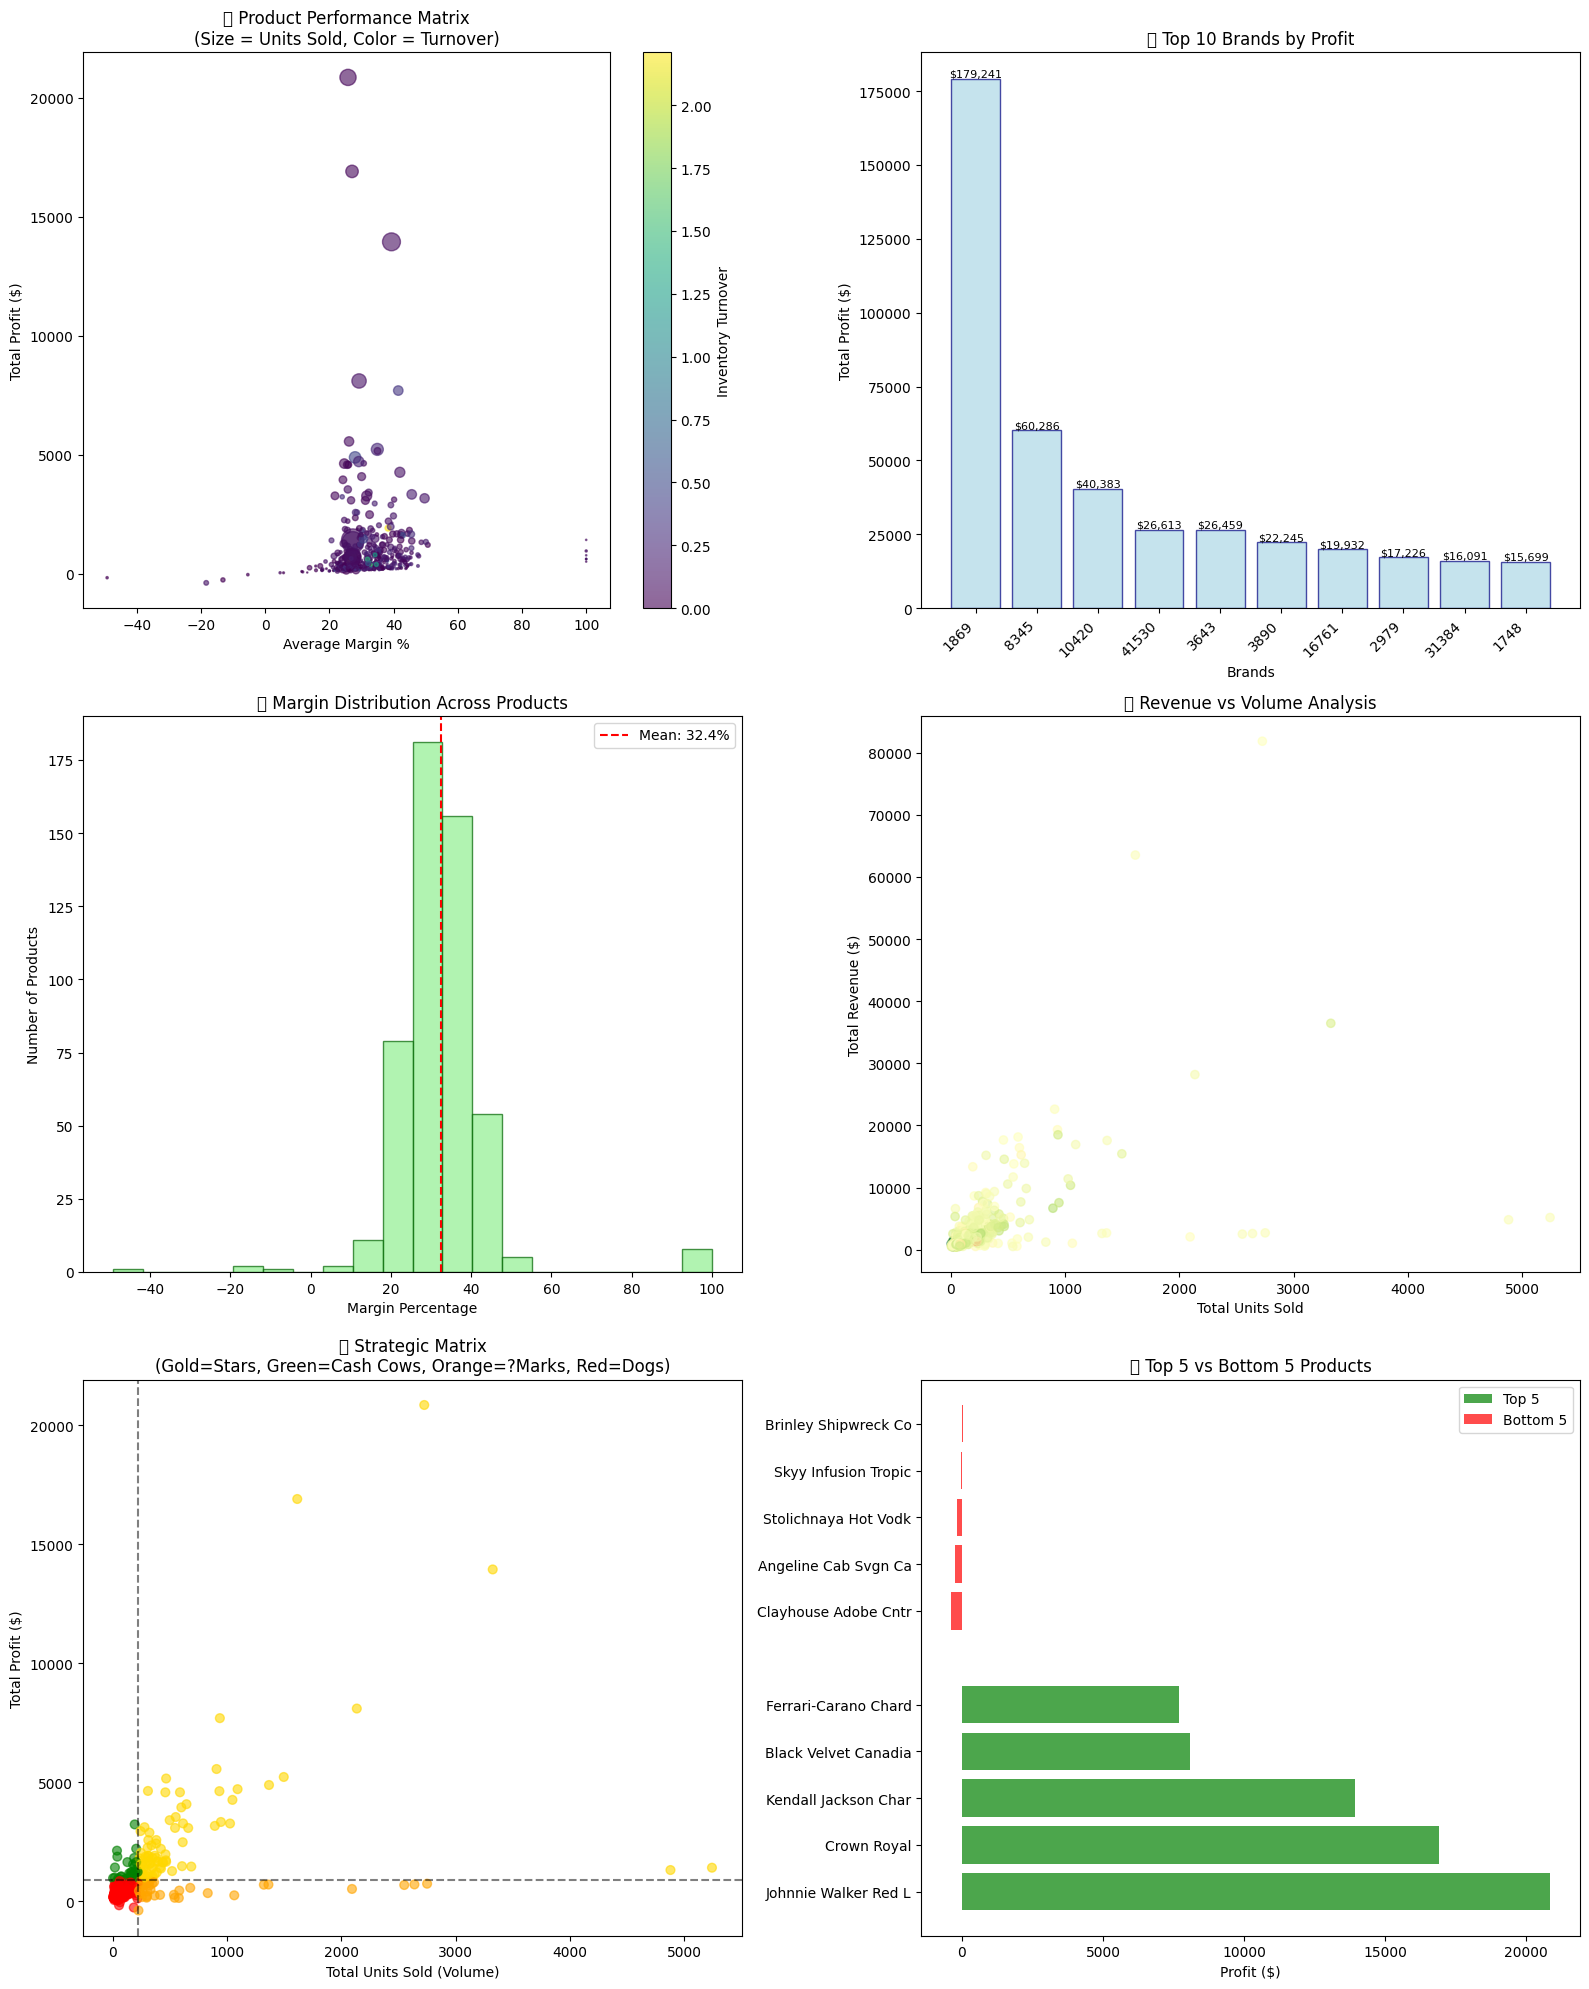

In [0]:
# ================================================================
# 10. ADVANCED VISUALIZATIONS
# ================================================================

def create_advanced_visualizations():
    """Create comprehensive visualizations for strategic insights"""
    
    # Convert to Pandas for advanced plotting (limit data size for free tier)
    product_viz_data = product_summary.filter(F.col("TotalRevenue") > 500).limit(500).toPandas()
    brand_viz_data = brand_summary.limit(50).toPandas()
    
    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(16, 20))
    
    # 1. Profit vs Margin Scatter Plot (Bubble chart)
    ax1 = plt.subplot(3, 2, 1)
    scatter = ax1.scatter(product_viz_data['AvgMarginPercent'], 
                         product_viz_data['TotalProfit'],
                         s=product_viz_data['TotalUnitsSold']/20,
                         alpha=0.6, c=product_viz_data['AvgTurnover'], 
                         cmap='viridis')
    ax1.set_xlabel('Average Margin %')
    ax1.set_ylabel('Total Profit ($)')
    ax1.set_title('🎯 Product Performance Matrix\n(Size = Units Sold, Color = Turnover)')
    plt.colorbar(scatter, ax=ax1, label='Inventory Turnover')
    
    # 2. Brand Performance Comparison
    ax2 = plt.subplot(3, 2, 2)
    top_brands_viz = brand_viz_data.nlargest(10, 'TotalProfit')
    bars = ax2.bar(range(len(top_brands_viz)), top_brands_viz['TotalProfit'], 
                   color='lightblue', edgecolor='navy', alpha=0.7)
    ax2.set_xlabel('Brands')
    ax2.set_ylabel('Total Profit ($)')
    ax2.set_title('🏆 Top 10 Brands by Profit')
    ax2.set_xticks(range(len(top_brands_viz)))
    ax2.set_xticklabels(top_brands_viz['Brand'], rotation=45, ha='right')
    
    # Add profit values on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Margin Distribution
    ax3 = plt.subplot(3, 2, 3)
    ax3.hist(product_viz_data['AvgMarginPercent'], bins=20, alpha=0.7, 
             color='lightgreen', edgecolor='darkgreen')
    ax3.axvline(product_viz_data['AvgMarginPercent'].mean(), color='red', 
                linestyle='--', label=f"Mean: {product_viz_data['AvgMarginPercent'].mean():.1f}%")
    ax3.set_xlabel('Margin Percentage')
    ax3.set_ylabel('Number of Products')
    ax3.set_title('📊 Margin Distribution Across Products')
    ax3.legend()
    
    # 4. Revenue vs Units Sold
    ax4 = plt.subplot(3, 2, 4)
    ax4.scatter(product_viz_data['TotalUnitsSold'], product_viz_data['TotalRevenue'],
                alpha=0.6, c=product_viz_data['AvgMarginPercent'], cmap='RdYlGn')
    ax4.set_xlabel('Total Units Sold')
    ax4.set_ylabel('Total Revenue ($)')
    ax4.set_title('💰 Revenue vs Volume Analysis')
    
    # 5. Strategic Opportunities Matrix
    ax5 = plt.subplot(3, 2, 5)
    
    # Create strategic categories based on profit and volume
    high_profit = product_viz_data['TotalProfit'] > product_viz_data['TotalProfit'].quantile(0.75)
    high_volume = product_viz_data['TotalUnitsSold'] > product_viz_data['TotalUnitsSold'].quantile(0.75)
    
    colors = []
    for i in range(len(product_viz_data)):
        if high_profit.iloc[i] and high_volume.iloc[i]:
            colors.append('gold')      # Stars
        elif high_profit.iloc[i] and not high_volume.iloc[i]:
            colors.append('green')     # Cash Cows
        elif not high_profit.iloc[i] and high_volume.iloc[i]:
            colors.append('orange')    # Question Marks
        else:
            colors.append('red')       # Dogs
    
    ax5.scatter(product_viz_data['TotalUnitsSold'], product_viz_data['TotalProfit'], 
                c=colors, alpha=0.6, s=40)
    ax5.set_xlabel('Total Units Sold (Volume)')
    ax5.set_ylabel('Total Profit ($)')
    ax5.set_title('🎯 Strategic Matrix\n(Gold=Stars, Green=Cash Cows, Orange=?Marks, Red=Dogs)')
    
    # Add quadrant lines
    ax5.axhline(product_viz_data['TotalProfit'].quantile(0.75), color='black', linestyle='--', alpha=0.5)
    ax5.axvline(product_viz_data['TotalUnitsSold'].quantile(0.75), color='black', linestyle='--', alpha=0.5)
    
    # 6. Top vs Bottom Performers
    ax6 = plt.subplot(3, 2, 6)
    top_5 = product_viz_data.nlargest(5, 'TotalProfit')
    bottom_5 = product_viz_data.nsmallest(5, 'TotalProfit')
    
    y_pos = np.arange(len(top_5))
    ax6.barh(y_pos, top_5['TotalProfit'], color='green', alpha=0.7, label='Top 5')
    ax6.barh(y_pos + len(top_5) + 1, bottom_5['TotalProfit'], color='red', alpha=0.7, label='Bottom 5')
    
    ax6.set_yticks(list(y_pos) + list(y_pos + len(top_5) + 1))
    ax6.set_yticklabels(list(top_5['Description'].str[:20]) + list(bottom_5['Description'].str[:20]))
    ax6.set_xlabel('Profit ($)')
    ax6.set_title('📊 Top 5 vs Bottom 5 Products')
    ax6.legend()
    
    plt.tight_layout()
    plt.show()
    
    return product_viz_data

# Create visualizations
viz_data = create_advanced_visualizations()


In [0]:
# ================================================================
# 11. STRATEGIC RECOMMENDATIONS
# ================================================================

def generate_strategic_recommendations():
    """Generate actionable strategic recommendations"""
    
    recommendations = []
    
    # Calculate key metrics
    total_profit = product_summary.agg(F.sum("TotalProfit")).collect()[0][0]
    avg_margin = product_summary.agg(F.avg("AvgMarginPercent")).collect()[0][0]
    total_products = product_summary.count()
    
    recommendations.append(f"📈 **EXECUTIVE SUMMARY**")
    recommendations.append(f"   • Total Portfolio Profit: ${total_profit:,.2f}")
    recommendations.append(f"   • Average Margin: {avg_margin:.1f}%")
    recommendations.append(f"   • Total Products Analyzed: {total_products:,}")
    recommendations.append("")
    
    # Top recommendations
    recommendations.extend([
        "🎯 **STRATEGIC RECOMMENDATIONS**",
        "",
        "1. **FOCUS ON STAR PRODUCTS**:",
        "   • Double down on top 10 profit generators",
        "   • Ensure adequate inventory levels",
        "   • Consider premium positioning",
        "",
        "2. **OPTIMIZE PRICING STRATEGY**:",
        "   • Review high-volume, low-margin products",
        "   • Implement dynamic pricing for seasonal items",
        "   • Bundle slow-moving items with popular ones",
        "",
        "3. **INVENTORY MANAGEMENT**:",
        "   • Liquidate overstocked, low-turnover items",
        "   • Implement JIT for consistent movers",
        "   • Review supplier terms for better margins",
        "",
        "4. **PRODUCT PORTFOLIO OPTIMIZATION**:",
        "   • Rather than dropping products, consider:",
        "     - Repositioning in different market segments",
        "     - Seasonal promotions and bundles",
        "     - Supplier renegotiation",
        "     - Alternative distribution channels",
        "",
        "5. **PERFORMANCE MONITORING**:",
        "   • Implement monthly margin reviews",
        "   • Track inventory turnover by category",
        "   • Monitor competitive pricing"
    ])
    
    return recommendations

recommendations = generate_strategic_recommendations()
for rec in recommendations:
    print(rec)

print("\n" + "="*60)
print("✅ ANALYSIS COMPLETE - Strategic insights generated!")
print("="*60)

📈 **EXECUTIVE SUMMARY**
   • Total Portfolio Profit: $143,140,034.57
   • Average Margin: 38.1%
   • Total Products Analyzed: 267,552

🎯 **STRATEGIC RECOMMENDATIONS**

1. **FOCUS ON STAR PRODUCTS**:
   • Double down on top 10 profit generators
   • Ensure adequate inventory levels
   • Consider premium positioning

2. **OPTIMIZE PRICING STRATEGY**:
   • Review high-volume, low-margin products
   • Implement dynamic pricing for seasonal items
   • Bundle slow-moving items with popular ones

3. **INVENTORY MANAGEMENT**:
   • Liquidate overstocked, low-turnover items
   • Implement JIT for consistent movers
   • Review supplier terms for better margins

4. **PRODUCT PORTFOLIO OPTIMIZATION**:
   • Rather than dropping products, consider:
     - Repositioning in different market segments
     - Seasonal promotions and bundles
     - Supplier renegotiation
     - Alternative distribution channels

5. **PERFORMANCE MONITORING**:
   • Implement monthly margin reviews
   • Track inventory turno